# Autoregressive Tree HMM Demo

## Setup

In [9]:
import sys
import os

# sys.path.insert(0, os.path.expanduser('~/Documents/dynamax'))


In [34]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import seaborn as sns

from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from models.tarhmm import tARHMM
from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation
from dynamax.hidden_markov_model.models.tarhmm import tree_hmm_backward_filter
from typing import Callable, Optional
from dynamax.types import IntScalar, Float, Array


### Helper functions for plotting

In [11]:
sns.set_style("white")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink"
]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

## Sample from tree ARHMM


In [12]:
import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np
from jax.scipy.stats import multivariate_normal

def generate_tree_hmm_data(
    key,
    num_timesteps=200,
    max_cells=128,
    num_states=3,
    emission_dim=2,
    division_prob=0.1,
    death_prob=0.05,
    new_root_prob=0.4
):
    """
    Generates dummy data for a Tree HMM with AR Gaussian emissions.
    Uses STRICT UNIQUE IDS: Every biological cell gets a unique column index.
    - If a cell dies, its column is never reused.
    - If a cell divides, the parent column ends, and 2 NEW columns are assigned to children.
    - This makes the arrays sparse but guarantees Column K = Cell ID K.
    """
    k1, k2, k3, k4 = jr.split(key, 4)

    # --- 1. Define Model Parameters ---
    P_std = jnp.array([[0.8, 0.1, 0.1], [0.1, 0.8, 0.1], [0.1, 0.1, 0.8]])
    P_div = jnp.array([[0.9, 0.05, 0.05], [0.9, 0.05, 0.05], [0.9, 0.05, 0.05]])

    AR_weights = jr.normal(k1, (num_states, emission_dim, emission_dim)) * 0.5
    AR_biases = jr.normal(k2, (num_states, emission_dim))
    Emission_cov = jnp.eye(emission_dim) * 0.1

    # --- 2. Initialize Arrays ---
    parent_indices = np.zeros((num_timesteps, max_cells), dtype=np.int32)
    is_division_mask = np.zeros((num_timesteps, max_cells), dtype=bool)
    is_new_root_mask = np.zeros((num_timesteps, max_cells), dtype=bool)
    active_mask = np.zeros((num_timesteps, max_cells), dtype=bool)
    true_states = np.zeros((num_timesteps, max_cells), dtype=np.int32)
    observations = np.zeros((num_timesteps, max_cells, emission_dim))
    parent_observations = np.zeros((num_timesteps, max_cells, emission_dim))

    # --- 3. Simulation Loop ---
    
    # Global counter for Unique Cell IDs (mapped to column indices)
    # Start with 1 because 0 is taken by the initial root
    next_unique_id = 1 
    
    # State tracking: mapping column_idx -> {'state': int, 'obs': array}
    # Only currently active cells are in this map
    current_active_cells = {}

    # Initialize Root at t=0 in Column 0
    current_active_cells[0] = {
        'state': 0,
        'obs': np.zeros(emission_dim)
    }
    
    # Set t=0 arrays for Root
    active_mask[0, 0] = True
    is_new_root_mask[0, 0] = True
    true_states[0, 0] = 0
    observations[0, 0] = np.zeros(emission_dim)
    # parent_indices[0, 0] is 0
    # parent_observations[0, 0] is 0

    sim_keys = jr.split(k3, num_timesteps)
    new_root_keys = jr.split(k4, num_timesteps)

    for t in range(num_timesteps - 1):
        key_t = sim_keys[t]
        key_root_t = new_root_keys[t]
        
        next_active_cells = {}
        
        # A. Process Currently Active Cells
        sorted_ids = sorted(current_active_cells.keys())
        
        for pid in sorted_ids: # pid = Parent Column ID
            cell = current_active_cells[pid]
            
            fate_key, trans_key, obs_key = jr.split(jr.fold_in(key_t, pid), 3)
            fate_roll = float(jr.uniform(fate_key))
            
            fate = "continue"
            if fate_roll < death_prob:
                fate = "die"
            elif fate_roll < death_prob + division_prob:
                fate = "divide"
            
            # Check capacity before branching
            # If we need 2 new IDs but only have 1 slot left, force death or continue
            if fate == "divide" and next_unique_id + 2 > max_cells:
                fate = "die" # Out of unique IDs
            
            # --- Execute Fate ---
            
            if fate == "die":
                pass # Parent pid is not added to next_active_cells. It ends here.
                
            elif fate == "continue":
                # Cell persists in the SAME column (pid)
                target_id = pid
                
                # Transition
                state_probs = P_std[cell['state']]
                next_state = int(jr.choice(trans_key, np.arange(num_states), p=state_probs))
                
                # AR Obs (Input is Self)
                ar_input = cell['obs']
                mean = AR_weights[next_state] @ ar_input + AR_biases[next_state]
                next_obs = mean + np.array(jr.multivariate_normal(obs_key, np.zeros(emission_dim), Emission_cov))
                
                next_active_cells[target_id] = {'state': next_state, 'obs': next_obs}
                
                # Record in Arrays (t+1)
                active_mask[t+1, target_id] = True
                parent_indices[t+1, target_id] = pid # Parent is Self
                true_states[t+1, target_id] = next_state
                observations[t+1, target_id] = next_obs
                parent_observations[t+1, target_id] = ar_input
            
            elif fate == "divide":
                # Parent pid ends. Two NEW unique IDs are born.
                child_id_1 = next_unique_id
                child_id_2 = next_unique_id + 1
                next_unique_id += 2
                
                # Transition (Both children use Division matrix)
                state_probs = P_div[cell['state']]
                
                # Create Children
                # Note: We share the division transition logic for both but sample independently
                sub_keys = jr.split(trans_key, 2)
                obs_keys = jr.split(obs_key, 2)
                
                for i, cid in enumerate([child_id_1, child_id_2]):
                    # Sample State
                    next_state = int(jr.choice(sub_keys[i], np.arange(num_states), p=state_probs))
                    
                    # AR Obs (Input is 0.0 for division)
                    ar_input = np.zeros(emission_dim)
                    mean = AR_weights[next_state] @ ar_input + AR_biases[next_state]
                    next_obs = mean + np.array(jr.multivariate_normal(obs_keys[i], np.zeros(emission_dim), Emission_cov))
                    
                    next_active_cells[cid] = {'state': next_state, 'obs': next_obs}
                    
                    # Record
                    active_mask[t+1, cid] = True
                    parent_indices[t+1, cid] = pid # Parent is 'pid'
                    is_division_mask[t+1, cid] = True
                    true_states[t+1, cid] = next_state
                    observations[t+1, cid] = next_obs
                    parent_observations[t+1, cid] = ar_input # 0.0

        # B. Spontaneous New Roots
        if next_unique_id < max_cells:
            if float(jr.uniform(key_root_t)) < new_root_prob:
                new_root_id = next_unique_id
                next_unique_id += 1
                
                k_s, k_o = jr.split(key_root_t)
                next_state = int(jr.choice(k_s, np.arange(num_states)))
                
                # Input 0.0
                ar_input = np.zeros(emission_dim)
                mean = AR_biases[next_state]
                next_obs = mean + np.array(jr.multivariate_normal(k_o, np.zeros(emission_dim), Emission_cov))
                
                next_active_cells[new_root_id] = {'state': next_state, 'obs': next_obs}
                
                active_mask[t+1, new_root_id] = True
                is_new_root_mask[t+1, new_root_id] = True
                true_states[t+1, new_root_id] = next_state
                observations[t+1, new_root_id] = next_obs
                parent_observations[t+1, new_root_id] = ar_input
                parent_indices[t+1, new_root_id] = 0 # Dummy

        # Advance
        current_active_cells = next_active_cells

    # --- 4. Finalize ---
    observations_jax = jnp.array(observations)
    parent_obs_jax = jnp.array(parent_observations)
    active_mask_jax = jnp.array(active_mask)

    def compute_ar_log_prob(obs_t, obs_tm1, weights, biases, cov):
        means = jnp.einsum('kij,j->ki', weights, obs_tm1) + biases
        log_probs = jax.vmap(
            lambda m: multivariate_normal.logpdf(obs_t, m, cov)
        )(means)
        return log_probs

    log_likelihoods = jax.vmap(jax.vmap(
        lambda y, y_prev: compute_ar_log_prob(y, y_prev, AR_weights, AR_biases, Emission_cov)
    ))(observations_jax, parent_obs_jax)

    log_likelihoods = log_likelihoods * active_mask_jax[:, :, None]

    print(f"Generated sparse data for {num_timesteps} steps.")
    print(f"Total Unique Cells Created: {next_unique_id}")
    
    return {
        "initial_distribution": jnp.array([1.0, 0.0, 0.0]),
        "transition_matrices": (P_std, P_div),
        "log_likelihoods": log_likelihoods,
        "parent_indices": jnp.array(parent_indices),
        "is_division_mask": jnp.array(is_division_mask),
        "is_new_root_mask": jnp.array(is_new_root_mask),
        "active_mask": active_mask_jax,
        "observations": observations_jax,

        "parent_observations": parent_obs_jax,
        "params": {"AR_weights": AR_weights, "AR_biases": AR_biases, "cov": Emission_cov}
    }



key = jr.PRNGKey(1)
data = generate_tree_hmm_data(key, new_root_prob=0.3)

# Check Division Input
t = 5
print(f"\nTime {t} Snapshot:")
div_indices = jnp.where(data['is_division_mask'][t] & data['active_mask'][t])[0]
if len(div_indices) > 0:
    idx = div_indices[0]
    print(f"Dividing Cell Index: {idx}")
    print(f"Parent Observation (Should be 0.0): {data['parent_observations'][t][idx]}")
    print(f"Did it divide?: {data['is_division_mask'][t][idx]}")

Generated sparse data for 200 steps.
Total Unique Cells Created: 128

Time 5 Snapshot:


In [35]:
emissions = data['observations']
num_states = 3
emission_dim = 2
num_lags = 1

In [36]:
arhmm = tARHMM(num_states, emission_dim, num_lags=num_lags)
params, props = arhmm.initialize(key=jr.PRNGKey(1), method="kmeans", emissions=emissions)
inputs = arhmm.compute_inputs(emissions,                        
    data['parent_indices'],
    data['is_division_mask'],
    data['is_new_root_mask'],
    data['active_mask'])
# arhmm.e_step(params, emissions,inputs=inputs)


In [37]:
params

ParamsLinearTreeARHMM(initial=ParamsStandardHMMInitialState(probs=Array([0.8651381 , 0.02909769, 0.10576411], dtype=float32)), transitions=ParamsStandardHMMTransitions(transition_matrix=Array([[0.05861672, 0.6640048 , 0.2773785 ],
       [0.42456287, 0.0559652 , 0.51947194],
       [0.04436713, 0.17955199, 0.77608085]], dtype=float32)), division_transitions=ParamsStandardHMMTransitions(transition_matrix=Array([[0.01329545, 0.8212722 , 0.16543238],
       [0.07147674, 0.779085  , 0.14943835],
       [0.14579485, 0.71280545, 0.14139976]], dtype=float32)), emissions=ParamsLinearRegressionHMMEmissions(weights=Array([[[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]]], dtype=float32), biases=Array([[-2.522743  ,  1.5419133 ],
       [-1.9372153 ,  0.5719013 ],
       [-0.71598065,  1.2497399 ]], dtype=float32), covs=Array([[[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]]], dtype=flo

In [38]:
data['active_mask'][:,2]

Array([False, False, False, False,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [39]:
data['is_division_mask'][:,3]

Array([False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [40]:
data['is_new_root_mask'][:,2]

Array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

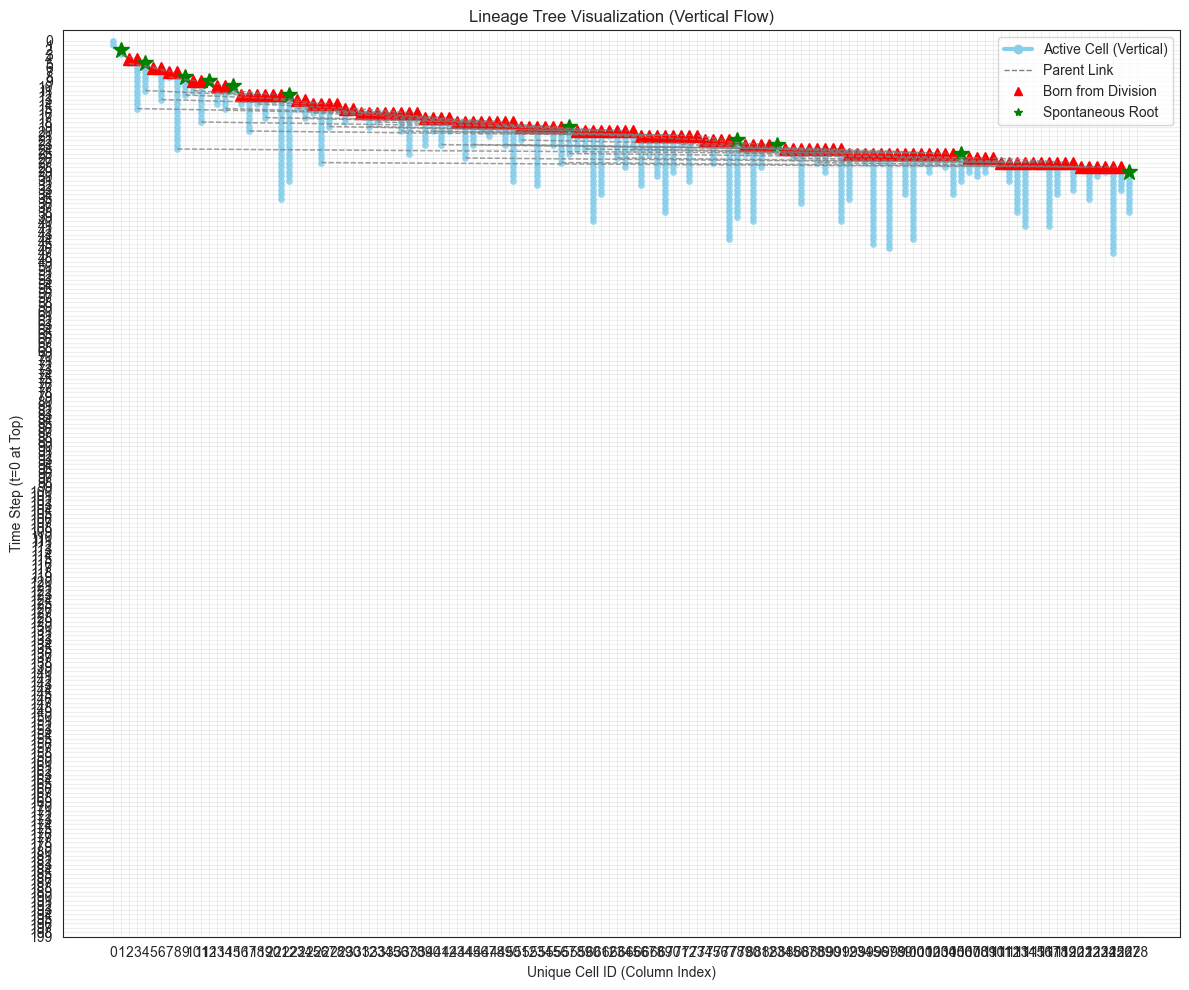

In [41]:
import matplotlib.pyplot as plt
import jax.random as jr
import jax.numpy as jnp
import numpy as np

# Import your generator
def visualize_lineage(data):
    """
    Visualizes the tree lineage vertically.
    Y-axis: Time (starts at 0 at the top, goes down).
    X-axis: Unique Cell ID.
    """
    parent_indices = np.array(data['parent_indices'])
    active_mask = np.array(data['active_mask'])
    is_new_root = np.array(data['is_new_root_mask'])
    is_division = np.array(data['is_division_mask'])
    
    T, MaxCells = active_mask.shape
    
    plt.figure(figsize=(12, 10))
    
    # 1. Draw Cell Tracks (Vertical Lines)
    # We iterate by ID to draw contiguous vertical lines for each unique cell
    
    for cell_id in range(MaxCells):
        # Find time points where this cell is active
        active_times = np.where(active_mask[:, cell_id])[0]
        
        if len(active_times) > 0:
            # Draw the life of the cell vertically
            # X = Cell ID (Constant), Y = Time (Variable)
            plt.plot([cell_id] * len(active_times), active_times, 
                     marker='o', markersize=4, linewidth=3, alpha=0.7, 
                     color='skyblue', label='Cell Life' if cell_id == 0 else "")
            
            # Label the start of the track
            t_start = active_times[0]
            
            # 2. Draw Connections to Parents (Upwards)
            if t_start > 0:
                parent_id = parent_indices[t_start, cell_id]
                
                # Check if this is a "New Root" (Spontaneous) or a Child
                if is_new_root[t_start, cell_id]:
                    # Star marker for spontaneous appearance
                    plt.plot(cell_id, t_start, marker='*', color='green', markersize=12, label='New Root' if cell_id==0 else "")
                else:
                    # Draw connection line from Parent(t-1) to Child(t)
                    # Parent is at (parent_id, t_start - 1)
                    # Child is at (cell_id, t_start)
                    plt.plot([parent_id, cell_id], [t_start - 1, t_start], 
                             color='gray', linestyle='--', linewidth=1, alpha=0.5)
                    
                    # If this was a division, mark the birth point
                    if is_division[t_start, cell_id]:
                         plt.plot(cell_id, t_start, marker='^', color='red', markersize=8, label='Division Child' if cell_id==0 else "")

    plt.ylabel("Time Step (t=0 at Top)")
    plt.xlabel("Unique Cell ID (Column Index)")
    plt.title("Lineage Tree Visualization (Vertical Flow)")
    
    # Invert Y axis so time goes down
    plt.gca().invert_yaxis()
    
    # Grid and Ticks
    plt.grid(True, alpha=0.3)
    # Set X ticks to integers for IDs, limiting to max active ID
    max_used_id = np.max(np.where(active_mask)[1])
    plt.xticks(np.arange(0, max_used_id + 2, 1))
    plt.yticks(np.arange(0, T, 1))
    
    # Create a custom legend manually to avoid duplicate labels
    from matplotlib.lines import Line2D
    custom_lines = [
        Line2D([0], [0], color='skyblue', lw=3, marker='o', label='Active Cell (Vertical)'),
        Line2D([0], [0], color='gray', lw=1, linestyle='--', label='Parent Link'),
        Line2D([0], [0], color='red', lw=0, marker='^', label='Born from Division'),
        Line2D([0], [0], color='green', lw=0, marker='*', label='Spontaneous Root')
    ]
    plt.legend(handles=custom_lines, loc='upper right')
    
    plt.tight_layout()
    plt.show()


    

visualize_lineage(data)

In [42]:
# data['is_division_mask'][:,4]
import pandas as pd
pd.DataFrame({'parent_idx':data['parent_indices'][:,4],'is_division':data['is_division_mask'][:,4],'is_new_root':data['is_new_root_mask'][:,4]})

,parent_idx,is_division,is_new_root
0,0,False,False
1,0,False,False
2,0,False,False
3,0,False,False
4,0,False,False
...,...,...,...
195,0,False,False
196,0,False,False
197,0,False,False
198,0,False,False


In [43]:
# arhmm._inference_args(params, emissions, inputs, data['parent_indices'], data['is_division_mask'], data['active_mask'],data['is_new_root_mask'])

In [ ]:
from dynamax.hidden_markov_model.models.tarhmm import tree_hmm_filter, tree_hmm_two_filter_smoother
# post = tree_hmm_filter(*arhmm._inference_args(params, emissions, inputs, data['parent_indices'], data['is_division_mask'], data['active_mask'],data['is_new_root_mask']))

In [47]:
input_fwd = arhmm._inference_args(params, emissions, inputs, data['parent_indices'], data['is_division_mask'], data['active_mask'],data['is_new_root_mask'])

In [ ]:
def inputs_for_backward_filter(
    initial_distribution,   # (num_states,)
    transition_matrices,    # tuple of (P_std, P_div) each (num_states, num_states)
    log_likelihoods,        # (T, MAX_CELLS, K)
    parent_indices,         # (T, MAX_CELLS)
    is_division_mask,       # (T, MAX_CELLS)
    active_mask,            # (T, MAX_CELLS)
    is_new_root_mask,       # (T, MAX_CELLS)
    transition_fn: Optional[Callable[[IntScalar], Float[Array, "num_states num_states"]]] = None,
    division_transition_fn: Optional[Callable[[IntScalar], Float[Array, "num_states num_states"]]] = None
):
    return transition_matrices, log_likelihoods, parent_indices, is_division_mask, active_mask, is_new_root_mask
# transition_matrices, log_likelihoods, parent_indices, is_division_mask, active_mask, is_new_root_mask = inputs_for_backward_filter(*input_fwd)
# log_normalizer, backward_pred_probs = tree_hmm_backward_filter(*inputs_for_backward_filter(*input_fwd))

In [49]:
# cell_id = 3
# pd.DataFrame({'active':data['active_mask'][:,cell_id],'is_division':data['is_division_mask'][:,cell_id],'is_new_root':data['is_new_root_mask'][:,cell_id],'parent_id':data['parent_indices'][:,cell_id]})

In [50]:
# post = tree_hmm_two_filter_smoother(*input_fwd)

In [51]:
import importlib

In [ ]:
# from dynamax.hidden_markov_model.models import tarhmm
# importlib.reload(tarhmm)
# from dynamax.hidden_markov_model.models.tarhmm import _compute_sum_transition_probs
# trans = _compute_sum_transition_probs(transition_matrices, post,   parent_indices,
#     is_division_mask,
#     active_mask,
#     is_new_root_mask)

In [31]:
# assert trans[0][1].sum() == is_division_mask.sum()

In [52]:
arhmm = tARHMM(num_states, emission_dim, num_lags=num_lags)
params, props = arhmm.initialize(key=jr.PRNGKey(1), method="kmeans", emissions=emissions)
inputs = arhmm.compute_inputs(emissions,                        
    data['parent_indices'],
    data['is_division_mask'],
    data['is_new_root_mask'],
    data['active_mask'])
# arhmm.e_step(params, emissions,inputs=inputs)

# e_step = arhmm.e_step(params,emissions,inputs,data['parent_indices'],data['is_division_mask'],data['active_mask'],data['is_new_root_mask'])

In [53]:
fitted_params, lps = arhmm.fit_em(params, props, emissions, inputs=inputs,
    parent_indices=data['parent_indices'],
    is_division_mask=data['is_division_mask'],
    active_mask=data['active_mask'],
    is_new_root_mask=data['is_new_root_mask'])

In [ ]:
fitted_params.transitions

ParamsStandardHMMTransitions(transition_matrix=Array([[0.7721408 , 0.12150527, 0.1063539 ],
       [0.10435431, 0.81191313, 0.0837326 ],
       [0.11199865, 0.10293169, 0.78506964]], dtype=float32))

In [ ]:
fitted_params.division_transitions

ParamsStandardHMMTransitions(transition_matrix=Array([[0.8763195 , 0.06184029, 0.06184016],
       [0.85649854, 0.04932861, 0.09417281],
       [0.8613893 , 0.0693052 , 0.06930548]], dtype=float32))

In [ ]:
data['initial_distribution']

Array([1., 0., 0.], dtype=float32)

# TODO the initial distribution looks wrong still 

In [ ]:
fitted_params.emissions.weights

Array([[[-0.28189507,  0.10330311],
        [-1.020201  ,  0.25469014]],

       [[ 0.624746  , -0.8487009 ],
        [-0.6933967 ,  0.1849388 ]],

       [[ 0.39863995, -0.21802719],
        [ 0.01034083,  0.5372459 ]]], dtype=float32)

In [ ]:
data['params']['AR_weights']

Array([[[-0.28141668,  0.10828384],
        [-1.0228359 ,  0.2556912 ]],

       [[ 0.6254221 , -0.8385068 ],
        [-0.711782  ,  0.16041997]],

       [[ 0.38901988, -0.21117108],
        [ 0.01029548,  0.5349801 ]]], dtype=float32)

In [ ]:
fitted_params.initial

ParamsStandardHMMInitialState(probs=Array([0.30097088, 0.39801618, 0.30101296], dtype=float32))

In [ ]:
# Compare these two:
print("True Biases (Sorted):\n", jnp.sort(data['params']['AR_biases'][:, 0]))
print("Fitted Biases (Sorted):\n", jnp.sort(fitted_params.emissions.biases[:, 0]))

True Biases (Sorted):
 [-1.8742307   0.03189215  1.709014  ]
Fitted Biases (Sorted):
 [-1.8702618   0.01164948  1.6977013 ]
